# Evaluate single site simulation

This script generates key information on forest structure, composition, demography and biophysical characteristics on a single site simulation

# Import modules

In [1]:
import sys
#Path to the esm_tools.py script
sys.path.append('/glade/u/home/adamhb/Earth-System-Model-Tools/process_output')
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import functools
import cftime
import warnings
from matplotlib.dates import DateFormatter
import math
from datetime import datetime,timedelta
import esm_tools
import esm_viz
import importlib
importlib.reload(esm_tools)
importlib.reload(esm_viz)
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import cftime
import seaborn as sns

In [2]:
def running_mean(arr, window_size):
    """
    Calculate the running mean of a NumPy array.

    Parameters:
    - arr: NumPy array
        The input array for which you want to calculate the running mean.
    - window_size: int
        The size of the window used to compute the mean.

    Returns:
    - mean_arr: NumPy array
        An array containing the running mean values.
    """
    if window_size <= 0:
        raise ValueError("Window size must be a positive integer.")

    mean_arr = np.zeros_like(arr, dtype=float)  # Initialize the result array with zeros
    cumsum = np.cumsum(arr)  # Calculate the cumulative sum of the input array

    for i in range(len(arr)):
        if i < window_size - 1:
            # For the first few elements, use a smaller window if not enough data is available
            mean_arr[i] = cumsum[i] / (i + 1)
        else:
            # For the rest of the elements, use a window of size 'window_size'
            mean_arr[i] = (cumsum[i] - cumsum[i - window_size]) / window_size

    return mean_arr

def convert_cftime_to_datetime(cftime_obj):

    # Convert it to a datetime object
    datetime_obj = datetime(cftime_obj.year, cftime_obj.month, cftime_obj.day,
                            cftime_obj.hour, cftime_obj.minute, cftime_obj.second)

    return datetime_obj

# Setup

In [3]:
# Root path where case output lives
model_output_root = '/glade/scratch/adamhb/archive'

pft_names = ["pine","cedar","fir","shrub","oak"]
pft_colors = ['gold','darkorange','darkolivegreen','brown','springgreen']
n_pfts = len(pft_names)

cases = ['CZ2_equilibrium_110523_01_-17e2acb6a_FATES-8a054a12',
        'CZ2_equilibrium_110523_01_-17e2acb6a_FATES-8a054a12',
        'CZ2_equilibrium_110523_01_-17e2acb6a_FATES-8a054a12',
        'CZ2_equilibrium_110323_02_-17e2acb6a_FATES-8a054a12',
        'CZ2_equilibrium_110523_04_-17e2acb6a_FATES-8a054a12',
        'CZ2_equilibrium_110523_05_-17e2acb6a_FATES-8a054a12',
        'CZ2_equilibrium_110323_01_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_110923_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_110923_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_110923_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_110923_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_110923_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_110923_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_110923_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_1950_2020_111223_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_1950_2020_111223_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_1950_2020_111223_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_1950_2020_111223_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_1950_2020_111223_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_1950_2020_111223_-17e2acb6a_FATES-8a054a12',
        'CZ2_trans_1950_2020_111223_-17e2acb6a_FATES-8a054a12']

tags = ['0049','0054','0062','0023','0011','0012','0033',
        '0009','0005','0047','0002','0035','0050','0010',
        '0009','0005','0047','0002','0035','0050','0010']

# Load data

In [4]:
full_time_series_fields = [
          #have on to import these dimensions
          'FATES_SEED_PROD_USTORY_SZ',
          'FATES_VEGC_AP',
          #patches and cohorts
          'FATES_NPATCHES',
          'FATES_PATCHAREA_AP',
          'FATES_NPATCH_AP',
          #structure
          #'FATES_LAI_AP',
          #density
          'FATES_NPLANT_PF',
          'FATES_NPLANT_SZAPPF',
          'FATES_NPLANT_SZPF',
          #basal area
          'FATES_BASALAREA_SZPF',
          #crown_area
          'FATES_CANOPYCROWNAREA_PF',
          'FATES_CANOPYCROWNAREA_APPF',
          'FATES_CROWNAREA_APPF',
          'FATES_CROWNAREA_PF',
          #biomass
          #'FATES_VEGC_PF','FATES_VEGC_AP','FATES_VEGC_ABOVEGROUND','FATES_VEGC_ABOVEGROUND_SZPF',
          #growth
          #'FATES_DDBH_SZPF',
          #'FATES_DDBH_CANOPY_SZAP','FATES_DDBH_USTORY_SZAP',
          #mortality
          'FATES_MORTALITY_PF',
          #'FATES_MORTALITY_CANOPY_SZAP','FATES_MORTALITY_USTORY_SZAP',
          'FATES_MORTALITY_BACKGROUND_SZPF','FATES_MORTALITY_HYDRAULIC_SZPF','FATES_MORTALITY_CSTARV_SZPF',
          'FATES_MORTALITY_FIRE_SZPF','FATES_MORTALITY_CROWNSCORCH_SZPF',
          'FATES_MORTALITY_SENESCENCE_SZPF','FATES_MORTALITY_TERMINATION_SZPF','FATES_MORTALITY_LOGGING_SZPF',
          'FATES_MORTALITY_FREEZING_SZPF','FATES_MORTALITY_AGESCEN_SZPF','FATES_MORTALITY_IMPACT_SZPF',
          #seed production and recruitment
          #GPP and NPP
          'FATES_NPP_PF','FATES_NPP_SZPF',
          'FATES_RECRUITMENT_PF',
          #'FATES_AUTORESP_SZPF','FATES_MAINTAR_SZPF',
          #physical environment
          'SMP',
          #allocation
          #'FATES_STOREC_CANOPY_SZPF','FATES_STOREC_USTORY_SZPF',
          #fire
          'FATES_BURNFRAC','FATES_IGNITIONS','FATES_FIRE_INTENSITY_BURNFRAC',
          'FATES_FUEL_BULKD','FATES_FUEL_SAV',
          'FATES_FUEL_AMOUNT_AP',
          'FATES_FIRE_INTENSITY_BURNFRAC_AP',
          'FATES_BURNFRAC_AP',
          'FATES_NESTEROV_INDEX',
          'FATES_VEGC_ABOVEGROUND'
          ]

# Process data

In [5]:
def get_df_of_data(case,tag):
    
    print("Working on",case,"-",tag)
    
    equilibrium_to_TRANS_df = pd.DataFrame({'eq_tag':['0049','0054','0062','0023','0011','0012','0033'],
                                 'trans_tag':['0009','0005','0047','0002','0035','0050','0010']})
    
    
    if "equilibrium" in case:
        days_offset = -430 * 365.25
        print(case)
        print("offset",days_offset)
        
        years = list(range(2250, 2300))
        
        trans_tag = list(equilibrium_to_TRANS_df.loc[equilibrium_to_TRANS_df['eq_tag'] == tag]['trans_tag'])[0]
        
    elif "trans" in case:
        days_offset = 0
        trans_tag = tag
        years = list(range(1870,1951))
        
        if '1950_2020' in case:
            years = list(range(1951,2019))
    
    
    offset = timedelta(days=abs(days_offset))
    
    
    ds = esm_tools.load_fates_output_data(model_output_root=model_output_root,
                            case_name = case,
                            years = years,
                            fields = full_time_series_fields,
                            inst_tag = tag,
                            manual_path = None)
    
    dates = [convert_cftime_to_datetime(ds.time.values[i]) for i in range(len(ds.time.values))]
    
    if days_offset < 0:
        dates = [date - offset for date in dates]
    else:
        dates = [date + offset for date in dates]

    my_variables = ["Harmonized_tag","Date","BA_conifer","BA_oak","TreeStemD","Pct_shrub_cover_canopy",
                    "Pct_shrub_cover","Burned_area","Pct_conifer_cover_canopy","Pct_oak_cover_canopy"]
    my_dict = {}
    for i in my_variables:
        my_dict[i] = None

    my_dict['Harmonized_tag'] = [trans_tag] * len(dates)               
    my_dict["Date"] = dates
    my_dict['BA_conifer'] = esm_tools.get_conifer_basal_area_over_time(ds,dbh_min=10)
    my_dict['BA_oak'] = esm_tools.get_oak_basal_area_over_time(ds,dbh_min = 10)
    my_dict['TreeStemD'] = esm_tools.get_total_stem_den(ds,trees_only=True,dbh_min=10,over_time=True)
    my_dict['Pct_shrub_cover'] = esm_tools.get_pft_level_crown_area(ds,pft_index = 3,canopy_area_only = False,over_time=True)
    my_dict['Pct_shrub_cover_canopy'] = esm_tools.get_pft_level_crown_area(ds,pft_index = 3,canopy_area_only = True,over_time=True)
    my_dict['Pct_oak_cover_canopy'] = esm_tools.get_pft_level_crown_area(ds,pft_index = 4,canopy_area_only = True,over_time=True)
    my_dict['Pct_conifer_cover_canopy'] = esm_tools.get_conifer_crown_area(ds,canopy_area_only = True, over_time = True)
    burn_frac = esm_tools.get_mean_annual_burn_frac(ds,over_time=True)
    my_dict['Burned_area'] = running_mean(burn_frac, 36)

    # Get the 
    window = 36
    iterations = len(ds.time) // window
    PHS_dates = []
    PHS_3500 = []
    PHS_1700 = []
    for i in range(iterations):
        start_time_index = i * window
        end_time_index = min(start_time_index + 36, len(ds.time))
        mid_time_index = start_time_index + (window // 2)
        #print(start_time_index,"-",end_time_index)
        mid_date = convert_cftime_to_datetime(ds.time.values[mid_time_index])
        
        if days_offset < 0:
            mid_date = mid_date - offset
        else:
            mid_date = mid_date + offset
        
        PHS_dates.append(mid_date)
        PHS_3500.append(esm_tools.get_PHS_FLI_thresh_isel(ds,start_time_index,end_time_index,3500))
        PHS_1700.append(esm_tools.get_PHS_FLI_thresh_isel(ds,start_time_index,end_time_index,1700))

    PHS_dict = {}
    PHS_dict['Date']= PHS_dates
    PHS_dict['Harmonized_tag']= [trans_tag] * len(PHS_dates)  
    PHS_dict['Pct_high_severity_1700'] = PHS_1700
    PHS_dict['Pct_high_severity_3500'] = PHS_3500
    
    #print(my_dict)    
    df = pd.DataFrame(my_dict)
    df_PHS = pd.DataFrame(PHS_dict)
    
    return df, df_PHS

In [ ]:
# output_df = pd.DataFrame()
# output_df_PHS = pd.DataFrame()
# for i in range(len(cases)):
    
#     tmp_df, tmp_df_PHS = get_df_of_data(cases[i],tags[i])
#     output_df = pd.concat([output_df,tmp_df],axis = 0)
#     output_df_PHS = pd.concat([output_df_PHS,tmp_df_PHS],axis = 0)

# output_df_PHS.to_csv('/glade/u/home/adamhb/time_series_9_params_PHS_112923.csv')
# output_df.to_csv('/glade/u/home/adamhb/time_series_9_params_112923.csv')

In [6]:
# output_df_PHS = pd.read_csv('/glade/u/home/adamhb/time_series_9_params_PHS_112923.csv')
# output_df = pd.read_csv('/glade/u/home/adamhb/time_series_9_params_112823.csv')

output_df_PHS = pd.read_csv('/glade/u/home/adamhb/time_series_9_params_PHS_112923.csv')
output_df = pd.read_csv('/glade/u/home/adamhb/time_series_9_params_112923.csv')

output_df_PHS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              455 non-null    int64  
 1   Date                    455 non-null    object 
 2   Harmonized_tag          455 non-null    int64  
 3   Pct_high_severity_1700  452 non-null    float64
 4   Pct_high_severity_3500  452 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 17.9+ KB


# Make figures

In [8]:
# Replace 'your_file.csv' with the actual CSV file path
output_df = pd.read_csv('/glade/u/home/adamhb/time_series_9_params_112923.csv', parse_dates=['Date'], date_parser=pd.to_datetime)
output_df_PHS = pd.read_csv('/glade/u/home/adamhb/time_series_9_params_PHS_112923.csv', parse_dates=['Date'])

In [ ]:
# def get_datetime_obj(date_string, date_string_format = "%Y-%m-%d %H:%M:%S"):
#     return datetime.strptime(date_string, date_string_format)

# phs_dates = [get_datetime_obj(date) for date in output_df_PHS['Date']]

# days_offset = -430 * 365.25
# offset = timedelta(days=abs(days_offset))

# corrected_dates = 

### Forest metrics

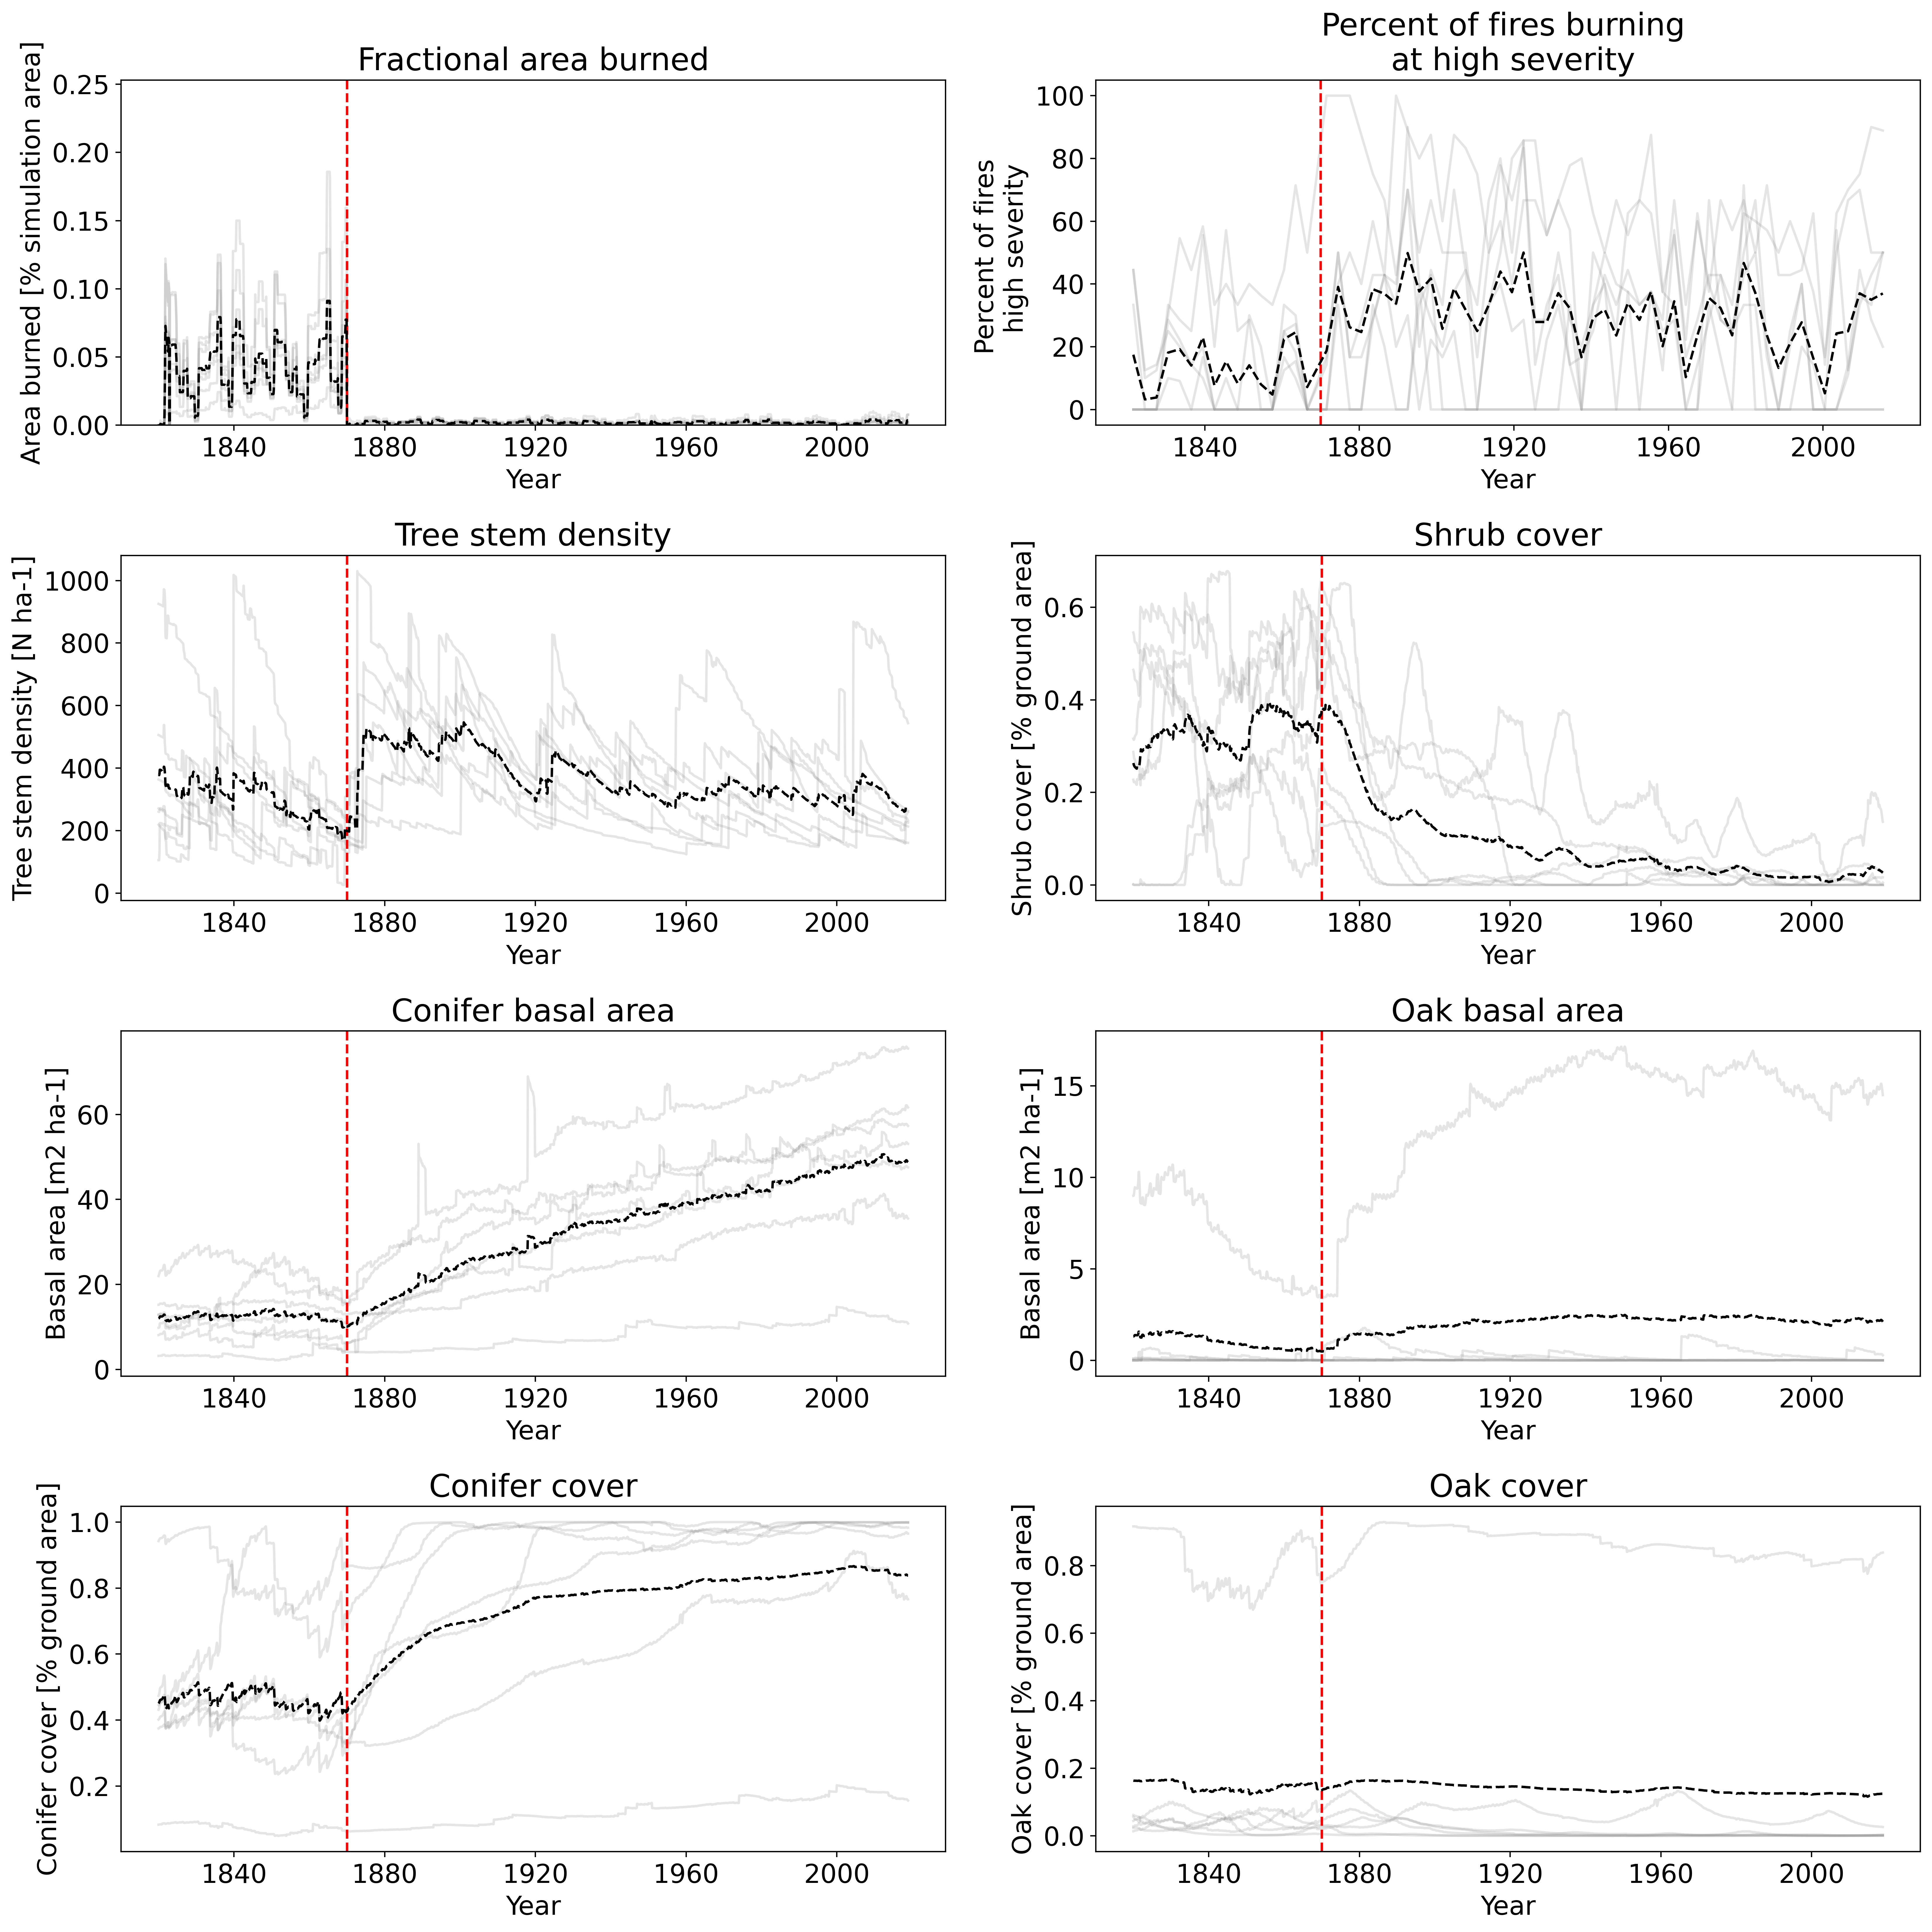

In [23]:
# Define the list of variables to plot in the desired order
variables = ["Burned_area", "Pct_high_severity_1700", "TreeStemD", "Pct_shrub_cover_canopy", "BA_conifer", "BA_oak",
             "Pct_conifer_cover_canopy","Pct_oak_cover_canopy"]

# Set the number of columns for the subplots
num_cols = 2

# Calculate the number of rows needed for subplots
num_rows = (len(variables) + num_cols - 1) // num_cols

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16.8, 16.8), dpi=400)
axes = axes.flatten()

# Loop through each variable and create a subplot

# Convert the year 1870 to a datetime object
year_1870 = datetime(1870, 1, 1)
plt.rc('font', size=16)

default_font_size = 16
for i, var in enumerate(variables):
    ax = axes[i]

    
    if var == "Pct_high_severity_1700":
        sns.lineplot(x="Date", y=var, units="Harmonized_tag", data=output_df_PHS, ax=ax, color = "grey", alpha = 0.2, estimator=None)
    else:
    # Use seaborn to create a line plot for each unique group with grey lines
        sns.lineplot(x="Date", y=var, units="Harmonized_tag", data=output_df, ax=ax, color = "grey", alpha = 0.2, estimator=None)

    
    
    
    # Set plot title and labels
    if var == "Burned_area":
        ax.set_title("Fractional area burned")
        ax.set_ylabel("Area burned [% simulation area]", fontsize = default_font_size)
        ax.set_ylim(ymin=0)  # Set ymin for the Burned_area panel to be 0
    elif var == "Pct_high_severity_1700":
        ax.set_title("Percent of fires burning \n at high severity")
        ax.set_ylabel("Percent of fires \n high severity", fontsize = default_font_size)
    elif var == "TreeStemD":
        ax.set_title("Tree stem density")
        ax.set_ylabel("Tree stem density [N ha-1]")
    elif var == "Pct_shrub_cover_canopy":
        ax.set_title("Shrub cover")
        ax.set_ylabel("Shrub cover [% ground area]")
    elif var == "BA_conifer":
        ax.set_title("Conifer basal area")
        ax.set_ylabel("Basal area [m2 ha-1]")
    elif var == "BA_oak":
        ax.set_title("Oak basal area")
        ax.set_ylabel("Basal area [m2 ha-1]")
    elif var == "Pct_conifer_cover_canopy":
        ax.set_title("Conifer cover")
        ax.set_ylabel("Conifer cover [% ground area]")
    elif var == "Pct_oak_cover_canopy":
        ax.set_title("Oak cover")
        ax.set_ylabel("Oak cover [% ground area]")

    ax.set_xlabel("Year")  # Change the x-axis label to "Year"
     # Add a vertical line at 1870 to all panels
    ax.axvline(x=year_1870, color="red", linestyle="--")

    # Add a black trend line representing the mean of the groups
    
    
    if var == "Pct_high_severity_1700":
        mean_values = output_df_PHS.groupby("Date")[var].mean()
    else:
        mean_values = output_df.groupby("Date")[var].mean()
    ax.plot(mean_values.index, mean_values.values, color="black", linestyle="--", label="Mean")

    # Remove the legend
    #ax.get_legend().remove()

# Remove any empty subplots
for i in range(len(variables), num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

plt.savefig("/glade/u/home/adamhb/california-fates/figures/response_to_fire_11_30_23.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

### PHS

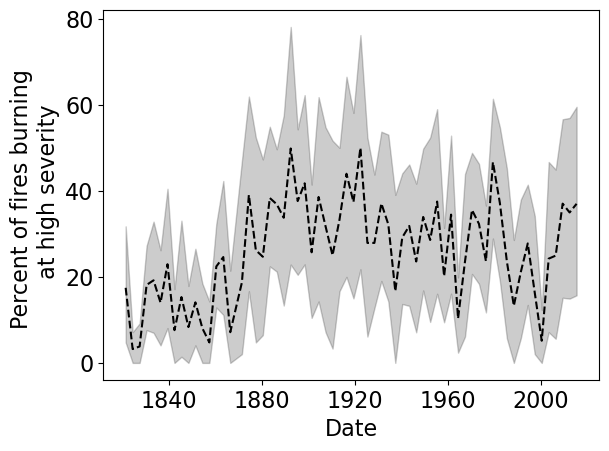

In [20]:
sns.lineplot(x="Date", y="Pct_high_severity_1700", data=output_df_PHS, color = "black",linestyle = "--")
plt.ylabel("Percent of fires burning \n at high severity")
plt.show()

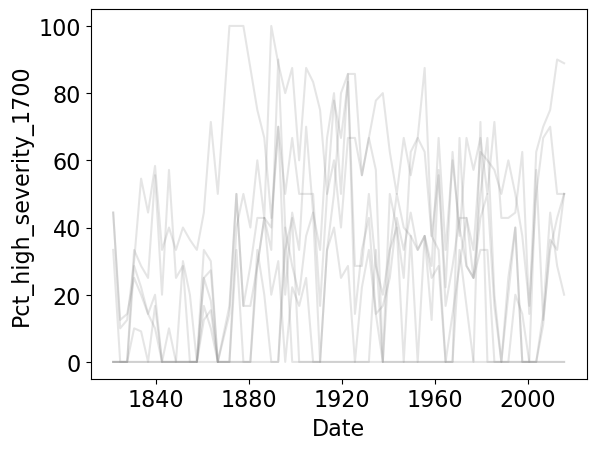

In [14]:

#fig, axes = plt.subplots(figsize=(8, 8), dpi=400)
sns.lineplot(x="Date", y='Pct_high_severity_1700', units="Harmonized_tag", data=output_df_PHS, color = "grey", alpha = 0.2, estimator=None)
#plt.show()

In [ ]:
len(output_df_PHS['Date'].unique())

In [ ]:
output_df_PHS.info

In [ ]:
455/9